# Raster - Meteorological Images

In [1]:
from datetime import datetime
from glob import glob
from IPython.display import display, HTML
from matplotlib import pyplot as plt
from osgeo import gdal, osr
# local
from AlertaDengue.settings import RASTER_PATH

import fiona
import geopandas as gpd
import numpy as np
import os
import rasterio
import rasterio.plot
# local
import AlertaDengue as alert_dengue

## Setting variables

In [2]:
shp_path = '%s/static/shapefile' % os.path.dirname(alert_dengue.__path__[0])
raster_dir_path = RASTER_PATH

local_mapfile_dir = '/tmp/mapfiles/%s'

In [3]:
# Rio de Janeiro's conf
geocode = 3304557
city_name = 'Rio de Janeiro'
alert_level = 2
disease = 'dengue'

In [4]:
# gdal error handler
def error_handler(err_level, err_no, err_msg):
    if err_level >= gdal.CE_Warning:
        raise RuntimeError(err_level, err_no, err_msg)
    else: 
        print(err_msg)

gdal.PushErrorHandler(error_handler)
gdal.PopErrorHandler()

## Check Shapefile

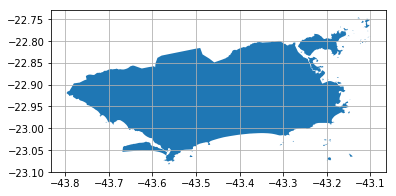

In [5]:
shapefile_path = os.path.join(shp_path, '%s.shp' % geocode)
gdf = gpd.GeoDataFrame.from_file(shapefile_path)
gdf.plot()

plt.grid(True)
plt.show()

In [6]:
# boundaries
gdf.bounds

,minx,miny,maxx,maxy
0,-43.796539,-23.082893,-43.099039,-22.74602


In [7]:
str_boundaries = [str(v) for v in gdf.bounds.iloc[0].values]
extent = ' '.join(str_boundaries)
extent_url = ','.join(str_boundaries)

In [8]:
# crs/srs
gdf.crs

{'init': 'epsg:4326'}

In [9]:
crs_proj = gdf.crs['init']
wms_srs = crs_proj.upper()

In [10]:
# using fiona to get coordintes
with fiona.open(shapefile_path, "r") as shapefile:
    features = [feature["geometry"] for feature in shapefile]

## Visualize raster images

In [11]:
def show_raster_info(src):
    """
    """
    try:
        for attr in dir(src):
            f = getattr(src, attr, None)
            
            if attr.startswith('_') or callable(f):
                continue
            
            print('=' * 80)
            print(attr)
            print(getattr(src, attr))
    except:
        pass
    
    print('=' * 80)
    for i in range(src.count):
        j = i+1
        print('colorinterp (%s):' % j, src.colorinterp(j))

    print('=' * 80)
    print('mask (dtype):', src.read_masks().dtype)

In [12]:
def show_raster_stats(src):
    """
    """
    print('=' * 80)
    print('shape:', src.read().shape)
    print('dtypes:', src.dtypes)
    print('nodata:', src.nodata)
    for band in src.read():
        if np.isnan(band.min()):
            band = np.nan_to_num(band)
            
        print('min:', band.min())
        print('mean:', band.mean())
        print('median:', np.median(band))
        print('max:', band.max())
        

In [13]:
def get_raster_key(raster_name, to_lower=True):
    """
    """
    if raster_name[-14:].count('_') == 2:
        raster_key = raster_name[:-15]
    else:
        raster_key = raster_name[:-19]
    
    if to_lower:
        raster_key = raster_key.lower()
        
    return raster_key

In [14]:
def get_date_from_file_name(raster_name, to_lower=True):
    """
    """
    if raster_name[-14:].count('_') == 2:
        dt = raster_name[-14:-4]
    else:
        dt = raster_name[-18:-8]

    return datetime.strptime(dt, '%Y_%m_%d')


In [15]:
data_range = {
    'ndvi': (-2000.0, +10000.0),
    'lst_day_1km': (0.0, 20000.0),
    'lst_night_1km': (-30.0, 30.0),
    'relative_humidity_2m_above_ground': (0.0, 100.0),
    'specific_humidity_2m_above_ground': (0.0, 1.0),
    'precipitation': (0, 200.0)
}

raster_classes = data_range.keys()

vmin: 0
vmax: 200.0
shape: (1, 870, 874)
dtypes: ('float32',)
nodata: None
min: 0.0
mean: 14.583477
median: 10.660233
max: 124.31807


/home/xmn/miniconda3/envs/alertadengue/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


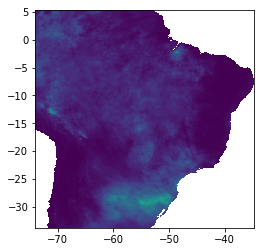

vmin: -2000.0
vmax: 10000.0
shape: (1, 870, 874)
dtypes: ('float64',)
nodata: None
min: -1979.0
mean: 4172.668986559352
median: 4355.0
max: 9703.0


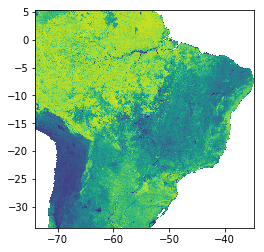

vmin: 0.0
vmax: 1.0
shape: (1, 870, 874)
dtypes: ('float64',)
nodata: None
min: 0.0006809501264902435
mean: 0.011985766706173186
median: 0.011694945517548554
max: 0.01804940886724864


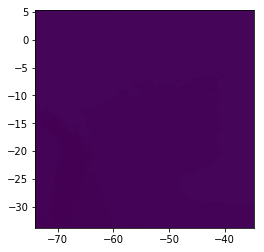

vmin: 0.0
vmax: 20000.0
shape: (1, 870, 874)
dtypes: ('float64',)
nodata: None
min: 0.0
mean: 10871.190677029907
median: 15150.0
max: 16793.0


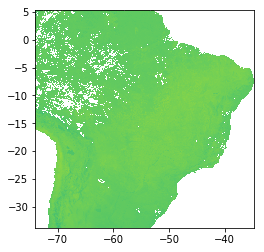

vmin: -30.0
vmax: 30.0
shape: (1, 870, 874)
dtypes: ('float64',)
nodata: None
min: -20.029999999999973
mean: 11.044911360109435
median: 13.630000000000052
max: 29.650000000000034


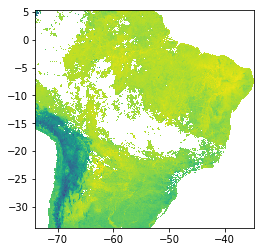

vmin: 0.0
vmax: 100.0
shape: (1, 870, 874)
dtypes: ('float64',)
nodata: None
min: 11.511718958305815
mean: 76.85799583095157
median: 79.62369926770528
max: 99.95286472638448


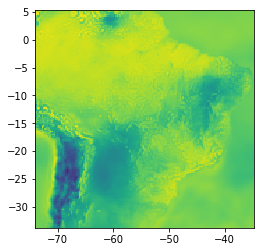

In [16]:
rasters = {}
str_numbers = ''.join([str(i) for i in range(10)])

meteorological_dir_path = os.path.join(raster_dir_path, 'meteorological')

meteorological_rasters_path = glob(
    os.path.join(meteorological_dir_path, 'country', '*')
)

for raster_class_dir_path in meteorological_rasters_path:
    # TODO: just the last one (memory economy)
    dt_check = None
    raster = None
    
    for raster_file_path in glob(os.path.join(raster_class_dir_path, '*')):
        raster_name = raster_file_path.split(os.sep)[-1]
        
        dt = get_date_from_file_name(raster_name)
        # get the last image
        
        if dt_check is None:
            dt_check = dt
        
        if dt < dt_check:
            continue

        if raster_name[0] in str_numbers or not raster_name[-3:] == 'tif':
            continue
        """
        # force statistic computation
        ds = gdal.Open(raster_file_path, gdal.GA_Update)
        for i in range(1, ds.RasterCount+1):
            ds.GetRasterBand(i).ComputeStatistics(False)
        ds = None  # save, close
        """

        src = rasterio.open(raster_file_path)
        raster = (raster_name, src)
    
    raster_name = raster[0]
    src = raster[1]
    
    display(HTML('\n<H3>%s</H3>' % raster_name))
    
    rasters[raster_name] = src
    raster_key = get_raster_key(raster_name)

    vmin = data_range[raster_key][0]
    vmax = data_range[raster_key][1]

    print('vmin:', vmin)
    print('vmax:', vmax)
    
    show_raster_stats(src)

    rasterio.plot.show(
        (src, 1), with_bounds=True, 
        vmin=vmin, vmax=vmax
    )

### Other references:

- [Meteorological Raster by Cities](./Raster-Change-Resolution.ipynb)